# Wine quality prediction

# Imports

In [1]:
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(level='INFO')

mlogger = logging.getLogger('matplotlib')
mlogger.setLevel(logging.WARNING)

In [2]:
import hopsworks
import pandas as pd
import missingno as msno

## Project setup

In [3]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/197786
Connected. Call `.close()` to terminate connection gracefully.


## Load data

In [4]:
# fetch dataset 
dataset_path = '../dataset/wine/wine.csv'
with open(dataset_path, 'r') as f:
    wine_df = pd.read_csv(f)

wine_df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [5]:
wine_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [6]:
wine_df.describe()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [7]:
# Drop the type column as it is not relevant for the analysis
wine_df = wine_df.drop([ 'type'], axis=1)
# make the type binary
# wine_df['type'] = wine_df['type'].map(lambda x: 1 if x == 'red' else 0)

In [8]:
# change the quality column to binary values 0 and 1 every value above 5 is good (1) and every value below 5 is bad (0)
wine_df['quality'] = wine_df['quality'].apply(lambda x: 1 if x > 5 else 0)

## Exploratory Data Analysis (EDA)


### Missing data

<Axes: >

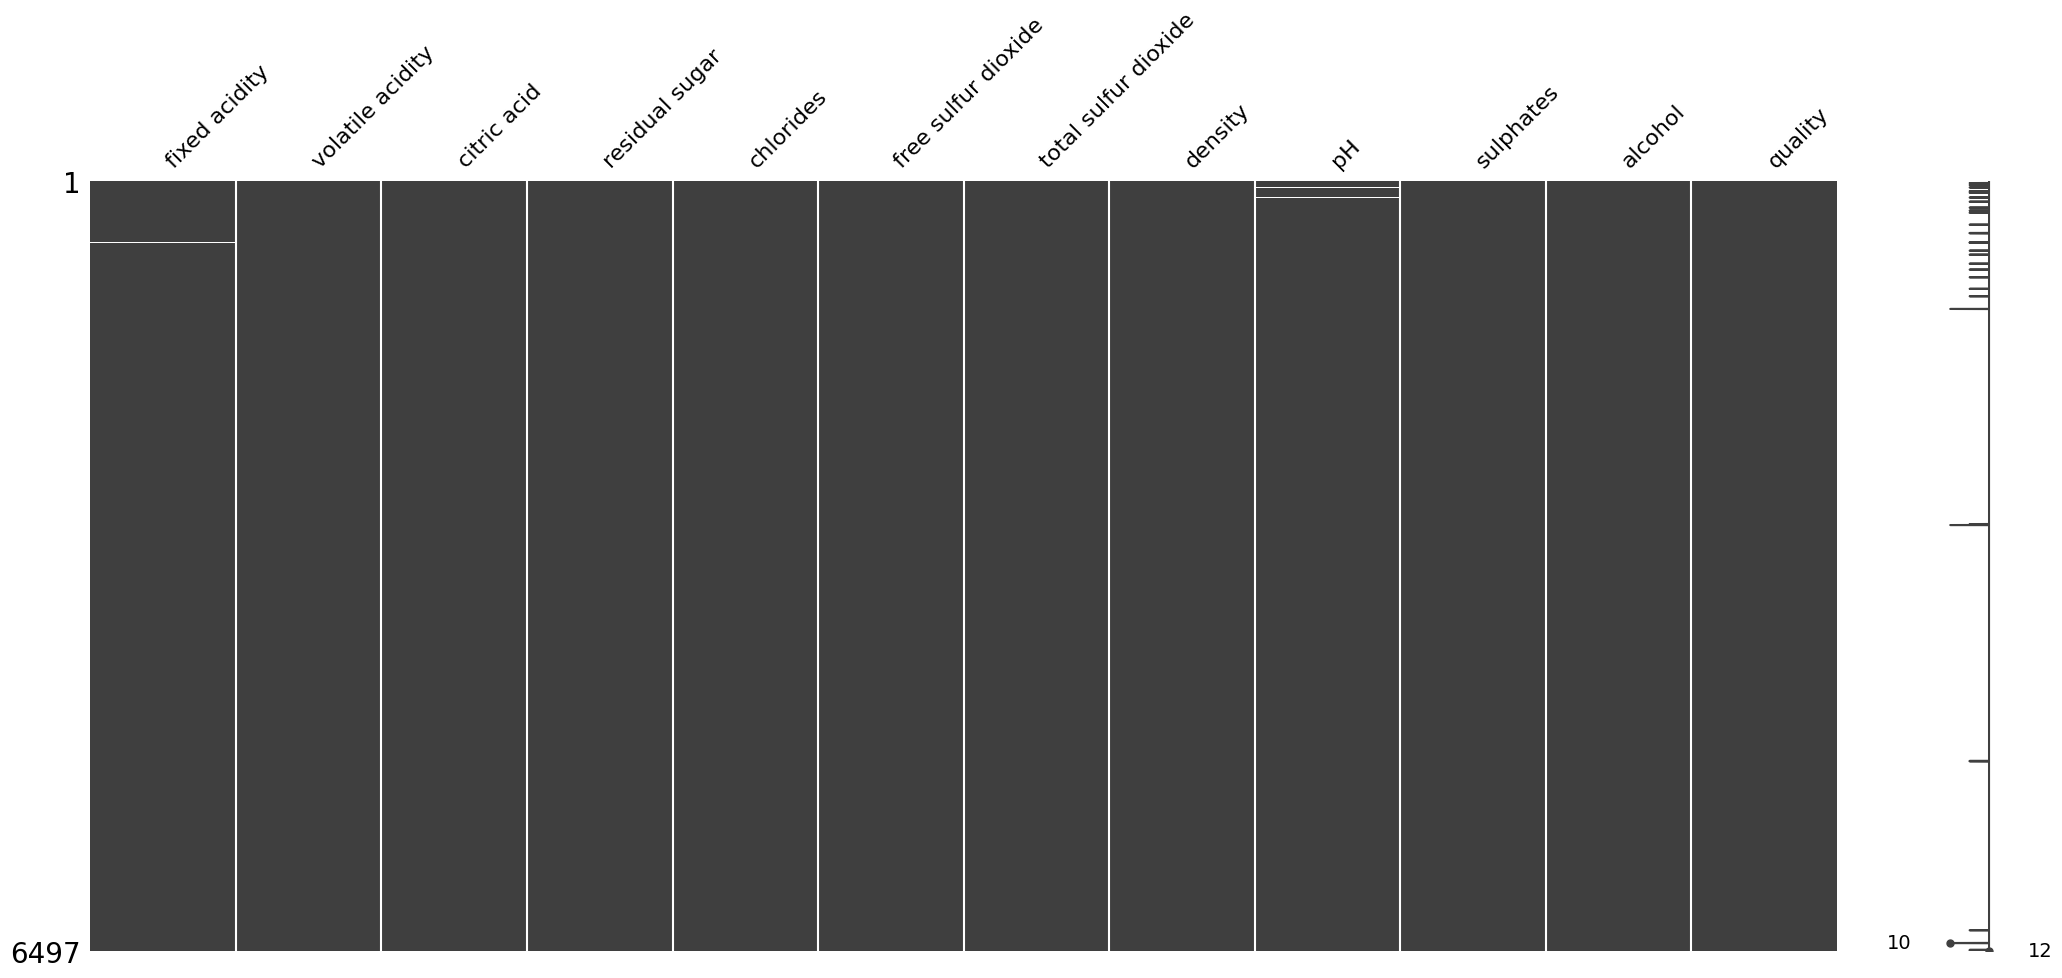

In [9]:
msno.matrix(wine_df)

In [10]:
# get each of the missing vlaue indexes for each column
missing_value_indexes = {}
for col in wine_df.columns:
    missing_value_indexes[col] = wine_df[wine_df[col].isnull()].index.tolist()
print('indexes of missing values:')
missing_value_indexes

indexes of missing values:


{'fixed acidity': [17, 174, 249, 267, 368, 518, 1079, 2902, 6428, 6429],
 'volatile acidity': [86, 521, 621, 812, 1079, 2894, 4895, 6486],
 'citric acid': [268, 909, 6320],
 'residual sugar': [33, 438],
 'chlorides': [98, 747],
 'free sulfur dioxide': [],
 'total sulfur dioxide': [],
 'density': [],
 'pH': [54, 139, 440, 587, 697, 972, 4892, 6428, 6429],
 'sulphates': [224, 2902, 6321, 6493],
 'alcohol': [],
 'quality': []}

### Univariate analysis

array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>],
       [<Axes: title={'center': 'residual sugar'}>,
        <Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>],
       [<Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'pH'}>],
       [<Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>]], dtype=object)

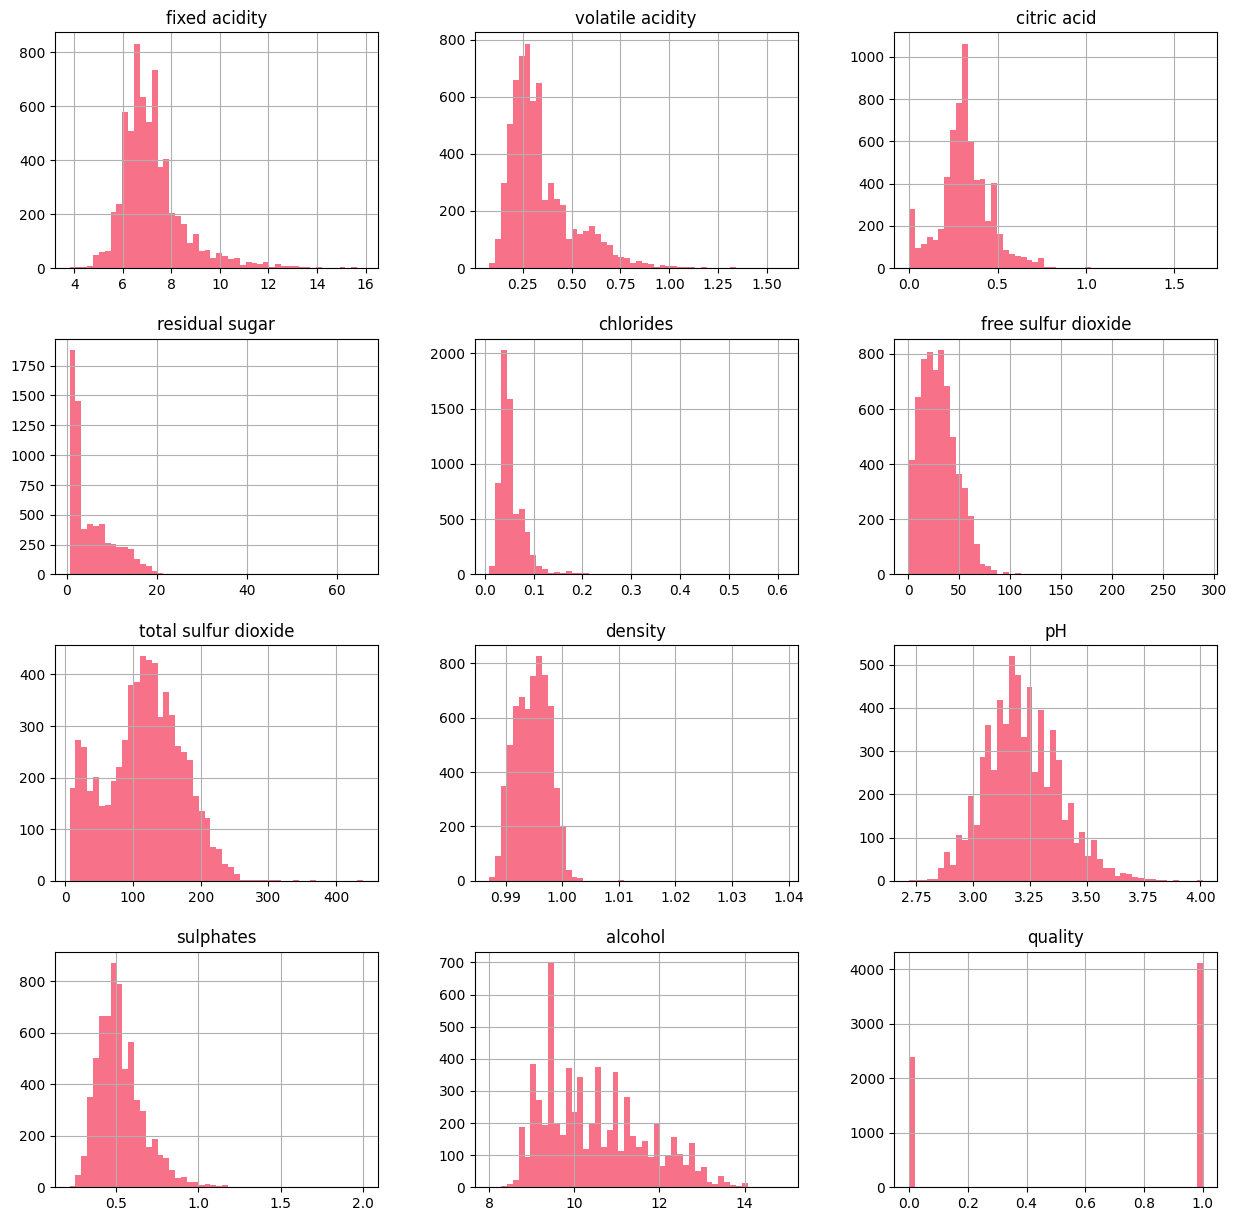

In [11]:
wine_df.hist(figsize=(15, 15), bins=50)

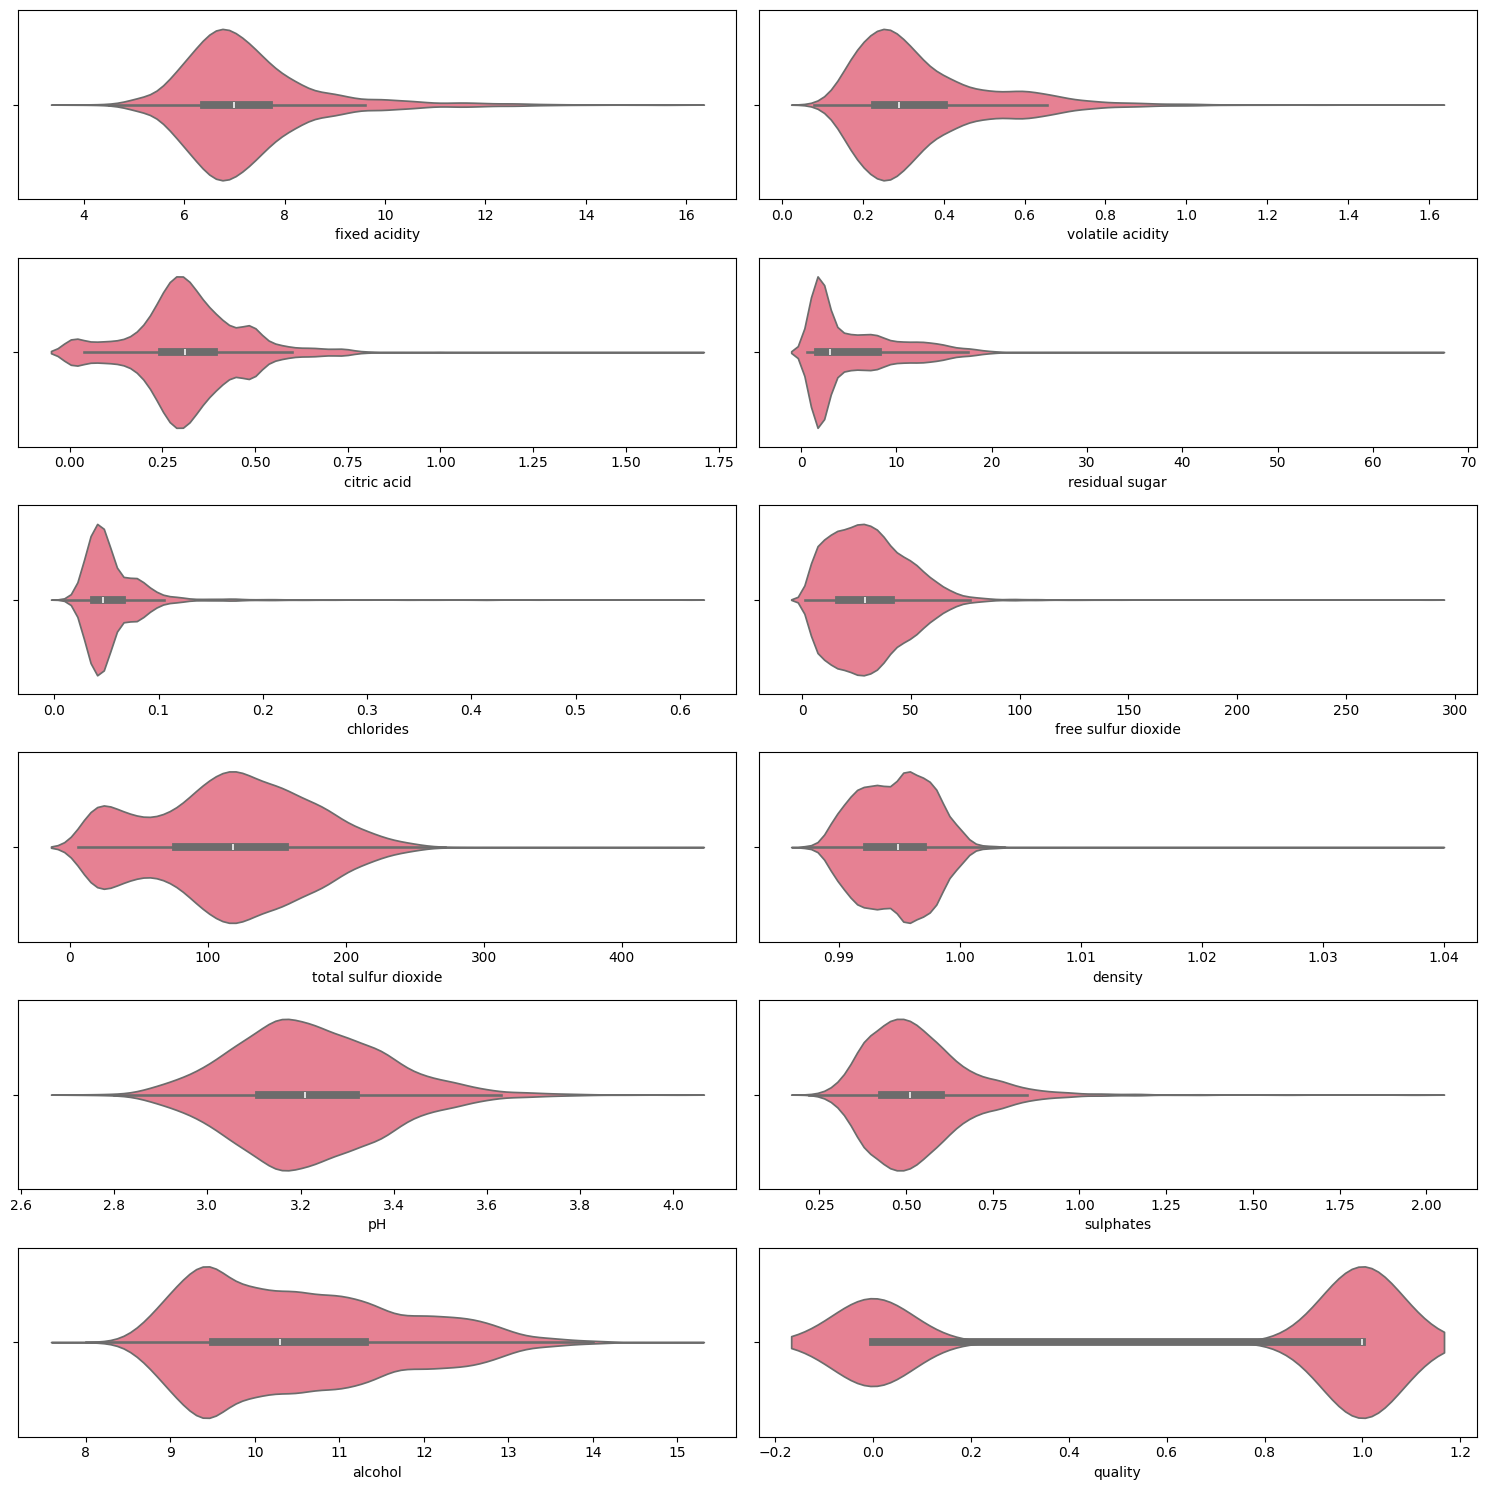

In [12]:
# violin plots using seaborn for the range of values for each feature in seperate plots
fig, axes = plt.subplots(6, 2, figsize=(15, 15))

axes = axes.flatten()
for i, col in enumerate(wine_df.columns):
    sns.violinplot(x=col, data=wine_df, ax=axes[i])

plt.tight_layout()
plt.show()


### Bivariate analysis

fixed acidity_1: [3.8, 15.6]

fixed acidity_0: [4.2, 15.9]

volatile acidity_1: [0.08, 1.04]

volatile acidity_0: [0.1, 1.58]

citric acid_1: [0.0, 1.66]

citric acid_0: [0.0, 1.0]

residual sugar_1: [0.7, 65.8]

residual sugar_0: [0.6, 23.5]

chlorides_1: [0.012, 0.415]

chlorides_0: [0.009, 0.611]

free sulfur dioxide_1: [1.0, 112.0]

free sulfur dioxide_0: [2.0, 289.0]

total sulfur dioxide_1: [6.0, 294.0]

total sulfur dioxide_0: [6.0, 440.0]

density_1: [0.98711, 1.03898]

density_0: [0.98722, 1.00315]

pH_1: [2.72, 4.01]

pH_0: [2.74, 3.9]

sulphates_1: [0.22, 1.95]

sulphates_0: [0.25, 2.0]

alcohol_1: [8.4, 14.2]

alcohol_0: [8.0, 14.9]

{'fixed acidity_1': [3.8, 15.6], 'fixed acidity_0': [4.2, 15.9], 'volatile acidity_1': [0.08, 1.04], 'volatile acidity_0': [0.1, 1.58], 'citric acid_1': [0.0, 1.66], 'citric acid_0': [0.0, 1.0], 'residual sugar_1': [0.7, 65.8], 'residual sugar_0': [0.6, 23.5], 'chlorides_1': [0.012, 0.415], 'chlorides_0': [0.009, 0.611], 'free sulfur dioxide_1'

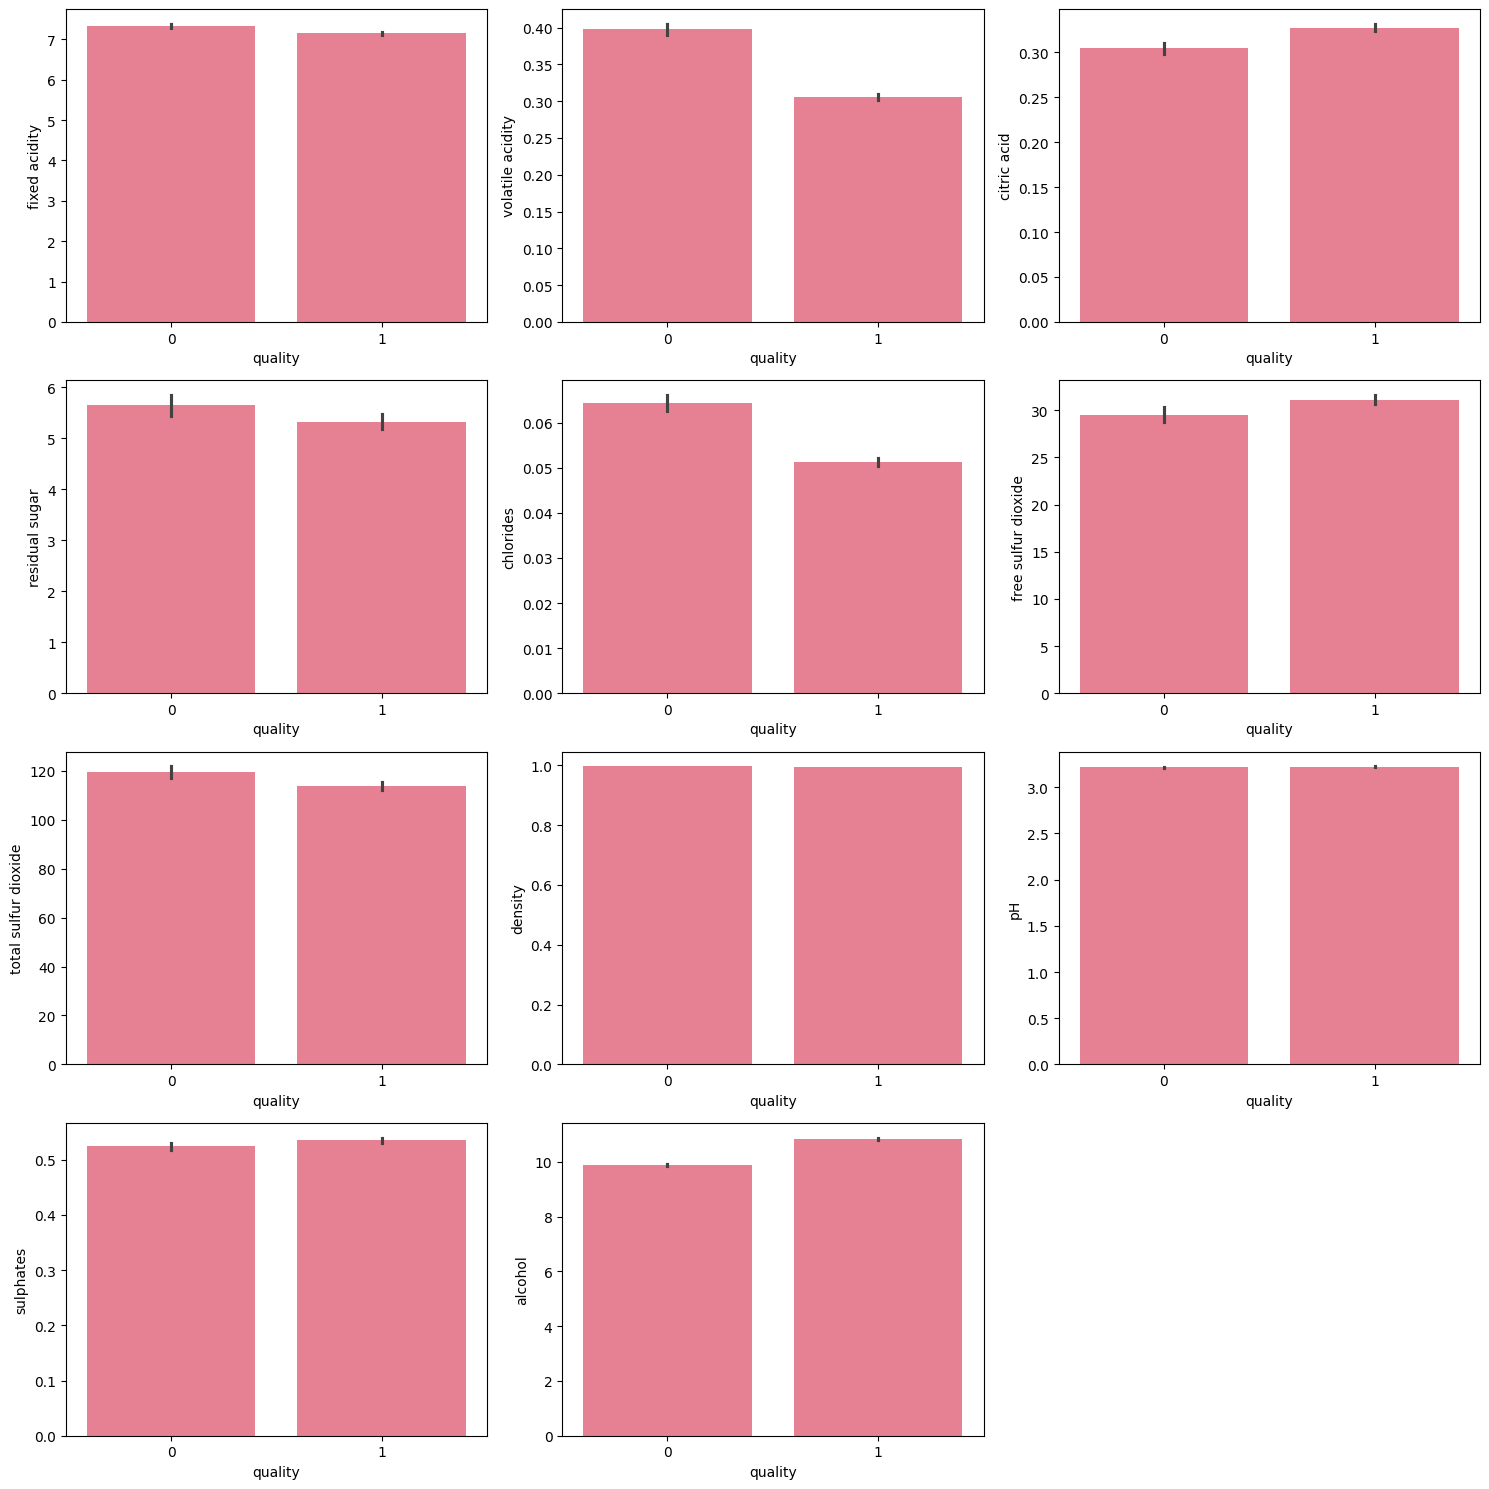

In [13]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15))

feature_ranges = {}
for i, col in enumerate(wine_df.columns):
    if col != 'quality':
        for quality in wine_df['quality'].unique():
            feature_ranges[col + '_' + str(quality)] = [wine_df[wine_df['quality'] == quality][col].min(), wine_df[wine_df['quality'] == quality][col].max()]
            print(col + '_' + str(quality) + ': ' + str(feature_ranges[col + '_' + str(quality)]) + '\n')
            
        sns.barplot(x='quality', y=col, data=wine_df, ax=axs[i//3, i%3])
# remove the empty plot
print(feature_ranges)
fig.delaxes(axs[3, 2])
plt.tight_layout()
plt.show()

### Multivariate analysis

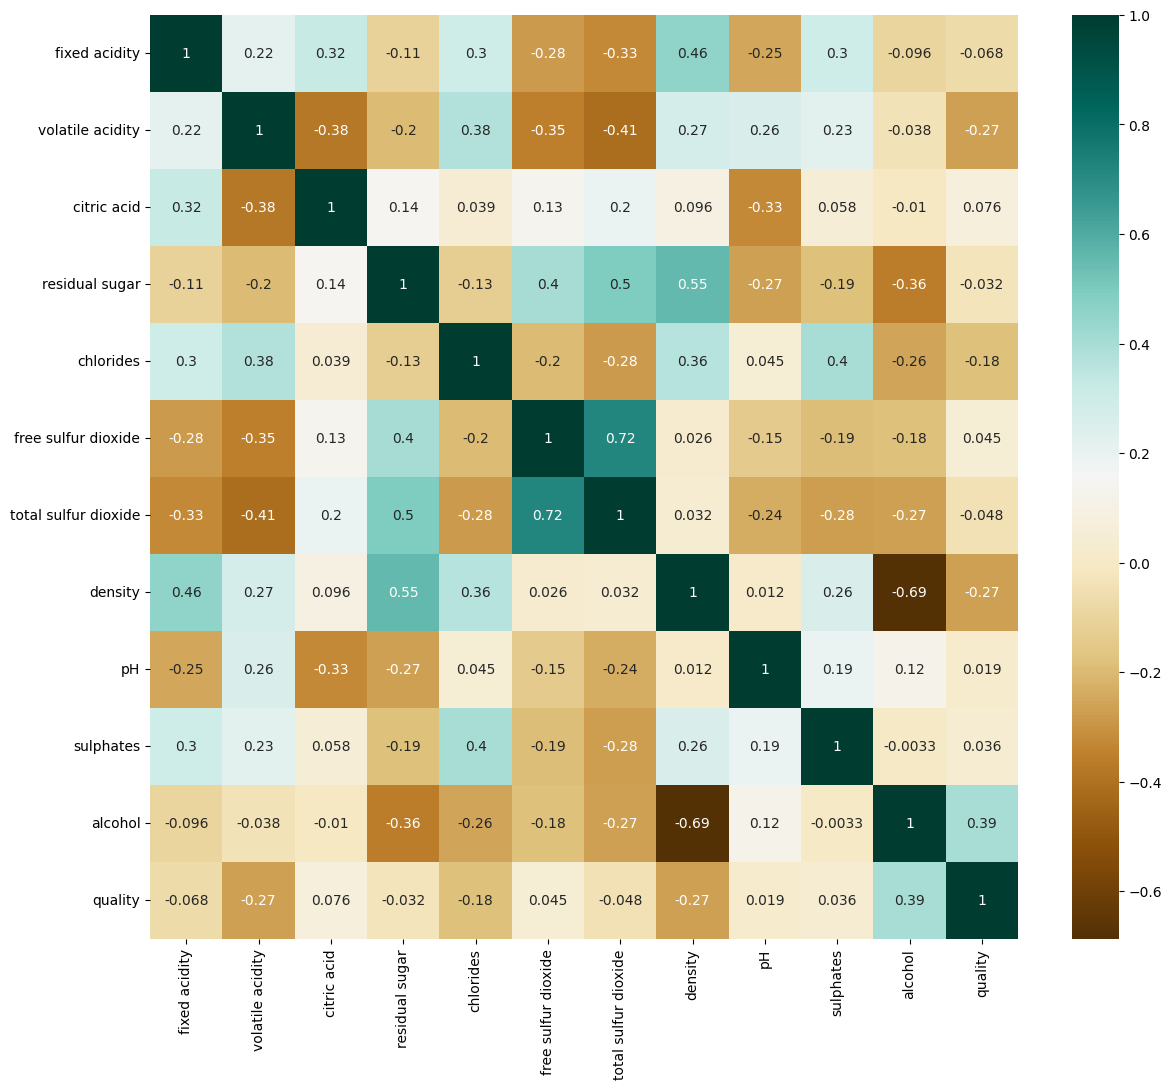

In [14]:
correlation = wine_df.corr()
sns.heatmap(correlation, annot=True, cmap='BrBG').figure.set_size_inches(14, 12)


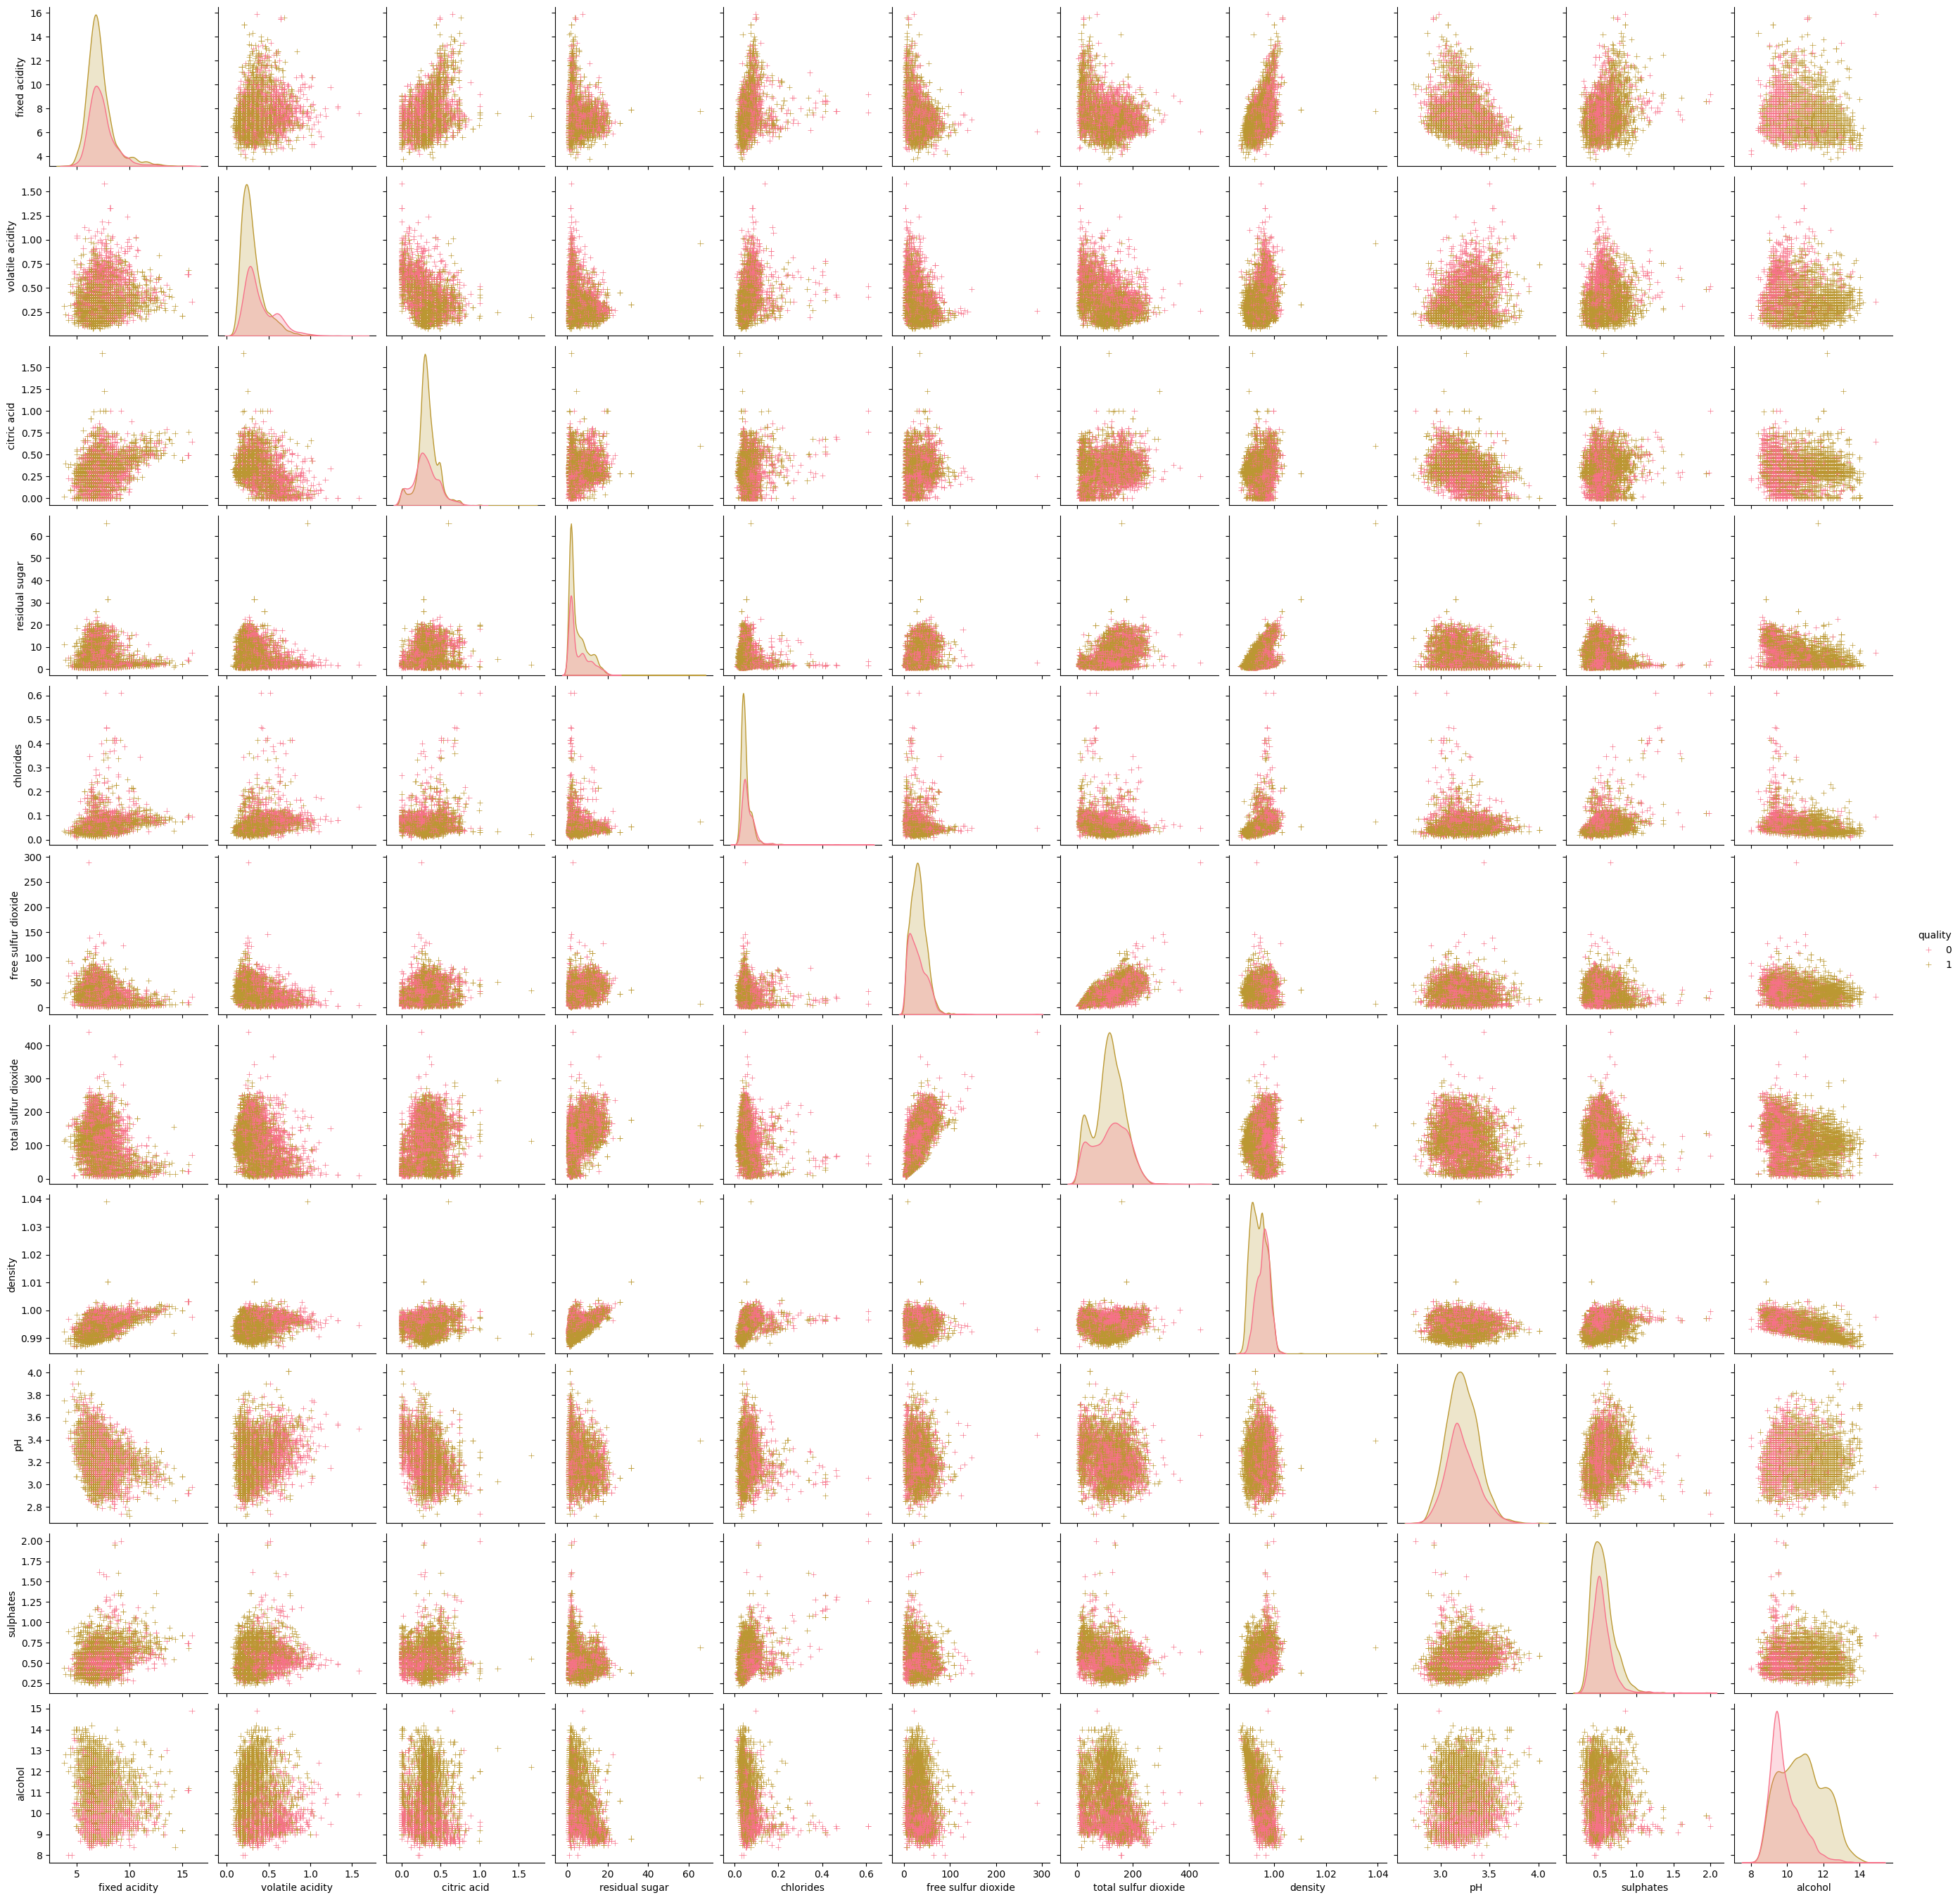

In [15]:
g = sns.pairplot(wine_df, hue='quality', markers='+')
plt.show()

### Insert our Iris DataFrame into a FeatureGroup
Let's write our historical iris feature values and labels to a feature group.
When you write historical data, this process is called `backfilling`.

In [16]:
# iris_fg = fs.get_or_create_feature_group(
#     name="wine",
#     version=1,
#     primary_key=["sepal_length","sepal_width","petal_length","petal_width"], 
#     description="Iris flower dataset")
# iris_fg.insert(iris_df)

### Data Validation
If you want, you can enable data validation for your feature group.
The code below will prevent iris flower data from being written your your feature group if you write values outside the expected ranges.

In [17]:
# from great_expectations.core import ExpectationSuite, ExpectationConfiguration

# def expect(suite, column, min_val, max_val):
#     suite.add_expectation(
#     ExpectationConfiguration(
#         expectation_type="expect_column_values_to_be_between",
#         kwargs={
#             "column":column, 
#             "min_value":min_val,
#             "max_value":max_val,
#         }
#     )
# )

In [18]:
# suite = ExpectationSuite(expectation_suite_name="iris_dimensions")

# expect(suite, "sepal_length", 4.5, 8.0)
# expect(suite, "sepal_width", 2.1, 4.5)
# expect(suite, "petal_length", 1.2, 7)
# expect(suite, "petal_width", 0.2, 2.5)
# iris_fg.save_expectation_suite(expectation_suite=suite, validation_ingestion_policy="STRICT")    